In [1]:
#导入基本的库
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")#忽略警告

In [2]:
#读取数据
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [3]:
#数据总览
train.head()
# test.head()
train.info()
# test.info()
# train.describe()
# test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
#离群点共147个，去掉
outliers=np.abs(train['count']-train['count'].mean()) > (3*train['count'].std())
outliers_num = len(train[outliers])
train.drop(index=train[outliers].index)
print("已删除",outliers_num,"个离群点")

已删除 147 个离群点


In [5]:
from datetime import datetime
import calendar
#对时间进行提取
def time_process(df):
    #年、月、日、小时特征提取
    df['year'] = pd.DatetimeIndex(df['datetime']).year
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df['day'] = pd.DatetimeIndex(df['datetime']).day
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour
    #将日期的礼拜数标出，以探究工作日、双休日的特征
    df['week'] = pd.DatetimeIndex(df['datetime']).weekofyear
    df['weekday'] = pd.DatetimeIndex(df['datetime']).dayofweek
    return df

train = time_process(train)
test = time_process(test)

In [6]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,52,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,52,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,52,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,52,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,52,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,51,2
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,51,2
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,51,2
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,51,2


In [7]:
#风速有很多缺失值，尝试使用随机森林基于气温、季节插值
from sklearn.ensemble import RandomForestClassifier
def wind_0_fill(df):
    wind_0 = df[df['windspeed']==0]
    wind_not0 = df[df['windspeed']!=0]
    y_label = wind_not0['windspeed']
    #猜测风速和天气以及时间都有关
    clf = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=0)
    windcolunms = ['season', 'weather', 'temp', 'atemp', 'humidity', 'hour', 'month']
    clf.fit(wind_not0[windcolunms], y_label.astype('int'))
    pred_y = clf.predict(wind_0[windcolunms])
    #预测结果填充
    wind_0['windspeed'] = pred_y
    df_rfw = wind_not0.append(wind_0)
    df_rfw.reset_index(inplace=True)
    return df_rfw

train = wind_0_fill(train)
test = wind_0_fill(test)

In [8]:
# 将行索引改为datetime
dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# 纳税日，仍需工作
train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# 感恩节，不需要工作
test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
#圣诞节，不工作
test.loc[get_day(pd.datetime(2011, 12, 24)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 26)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 31)), "workingday"] = 0

# 纳税日，不放假
train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

# 感恩节，放假
test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1
#圣诞节，放假
test.loc[get_day(pd.datetime(2011, 12, 24)), "holiday"] = 1
test.loc[get_day(pd.datetime(2011, 12, 31)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 12, 31)), "holiday"] = 1

#暴雨
test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#海啸
train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [9]:
def name_process(df):
    #季节、天气重命名，后续模型将用独热编码，易于可视化
    df['season2'] = df['season']
    df['weather2'] = df['weather']
    df['season2'] = df['season2'].map({1:'Spring',2:'Summer',3:'Fall',4:'Winter'})
    df['weather2'] = df['weather2'].map({1:'Clear',2:'Mist',3:'Light_Snow',4:'Heavy_Rain'})
#     df['month'] = df['month'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})   
    return df

train = name_process(train)
test = name_process(test)

<AxesSubplot:xlabel='hour', ylabel='count'>

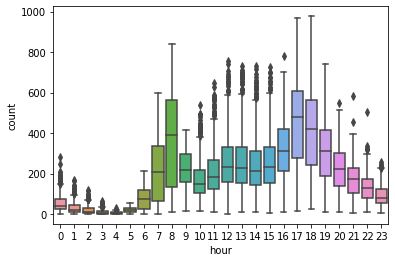

In [10]:
#可视化分析
#不同时间段--使用量
sns.boxplot(x='hour',y='count',data=train)

In [11]:
#根据数据，解译出使用量高峰时段
train['peak'] = train[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
test['peak'] = test[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

<AxesSubplot:xlabel='month', ylabel='count'>

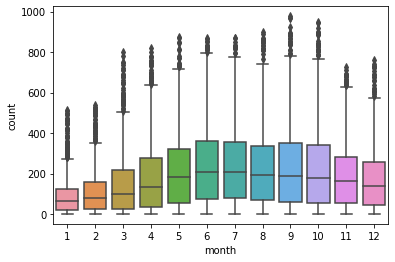

In [12]:
#不同月份--使用量
sns.boxplot(x='month',y='count',data=train)

<AxesSubplot:xlabel='season', ylabel='count'>

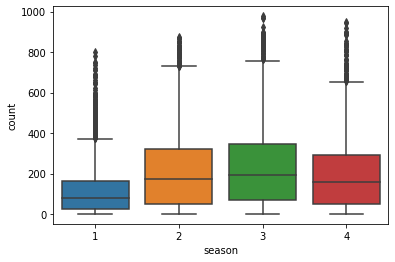

In [13]:
#不同季节--使用量
sns.boxplot(x='season',y='count',data=train)

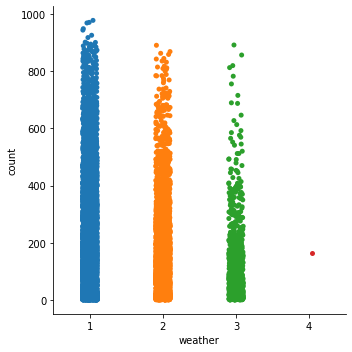

In [14]:
#不同天气--使用量
sns.catplot(x='weather',y='count',data=train)

<AxesSubplot:xlabel='weekday', ylabel='count'>

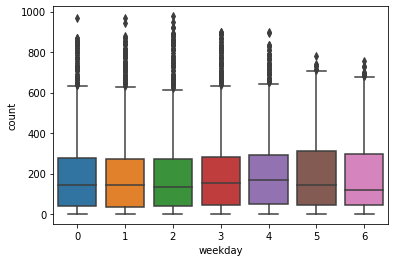

In [15]:
#不同工作日--使用量
sns.boxplot(x='weekday',y='count',data=train)

<AxesSubplot:xlabel='workingday', ylabel='count'>

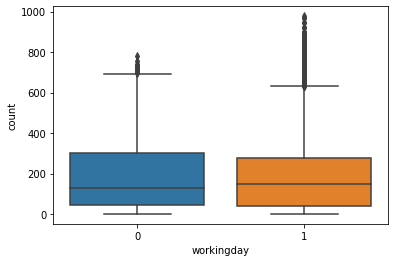

In [16]:
#是否工作日--使用量
sns.boxplot(x='workingday',y='count',data=train)

<AxesSubplot:xlabel='hour', ylabel='count'>

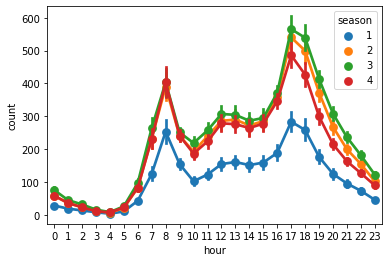

In [17]:
#季节--使用量
sns.pointplot(x='hour',y='count',hue='season',join=True,data=train)

<AxesSubplot:xlabel='hour', ylabel='count'>

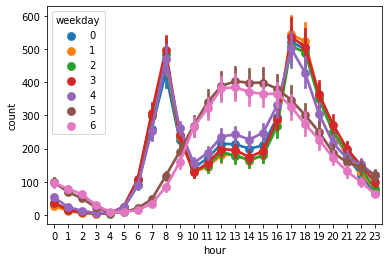

In [18]:
#工作日--使用量
sns.pointplot(x='hour',y='count',hue='weekday',join=True,data=train)

<AxesSubplot:xlabel='hour', ylabel='casual'>

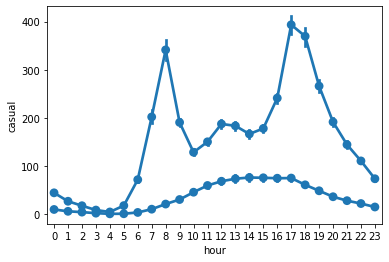

In [19]:
#注册用户--使用量
sns.pointplot(x='hour',y='registered',hue=None,join=True,data=train)
sns.pointplot(x='hour',y='casual',hue=None,join=True,data=train)

<AxesSubplot:xlabel='temp', ylabel='count'>

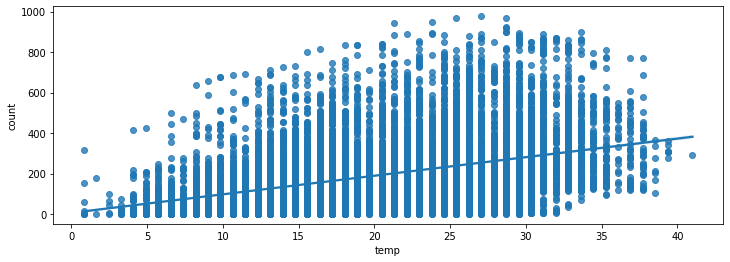

In [20]:
#温度--使用量
fig = plt.subplots(figsize=(12,4))
sns.regplot(x='temp',y='count',data=train)

<AxesSubplot:xlabel='atemp', ylabel='count'>

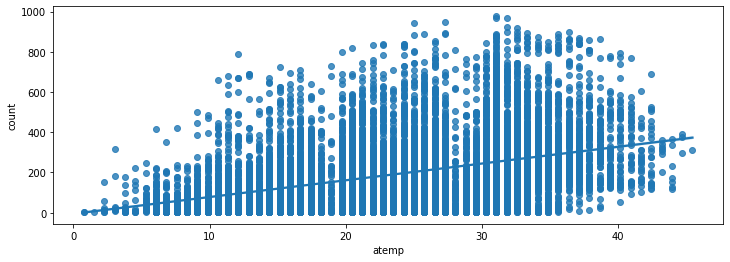

In [21]:
#体感温度--使用量
fig = plt.subplots(figsize=(12,4))
sns.regplot(x='atemp',y='count',data=train)

<AxesSubplot:xlabel='humidity', ylabel='count'>

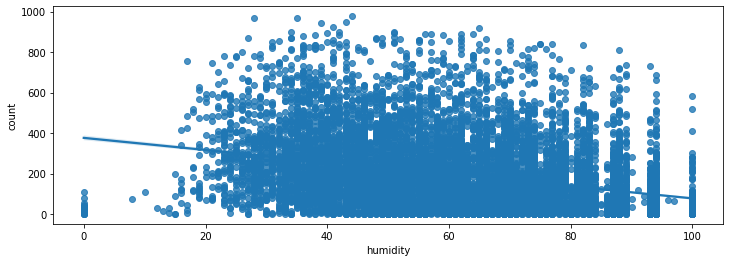

In [22]:
#湿度--使用量
fig = plt.subplots(figsize=(12,4))
sns.regplot(x='humidity',y='count',data=train)

<AxesSubplot:xlabel='windspeed', ylabel='count'>

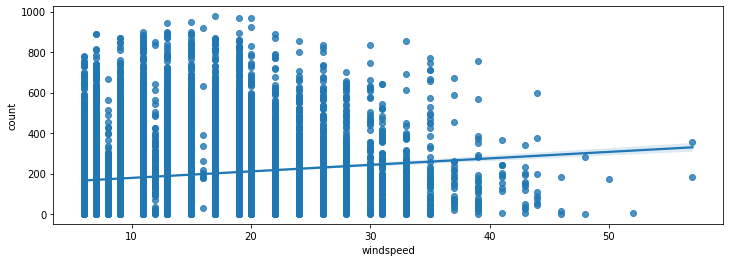

In [23]:
#风速--使用量
fig = plt.subplots(figsize=(12,4))
sns.regplot(x='windspeed',y='count',data=train)

<AxesSubplot:>

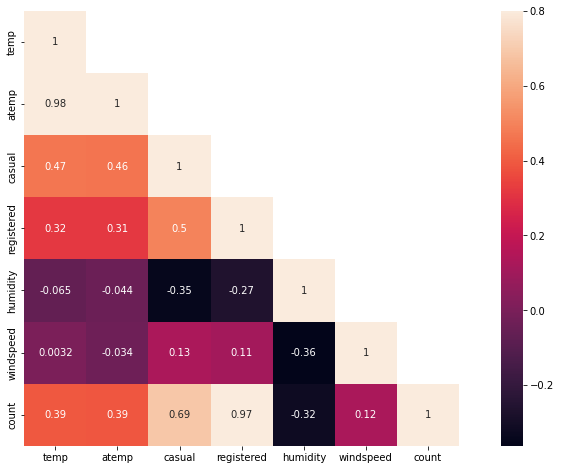

In [24]:
#连续变量的相关性分析
corr = train[['temp','atemp','casual','registered','humidity','windspeed','count']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(corr,mask=mask,vmax=.8,square=True,annot=True)

<AxesSubplot:ylabel='Density'>

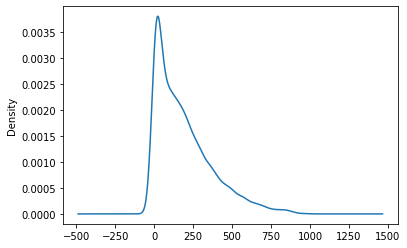

In [25]:
#样本正态分布情况一般
train['count'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

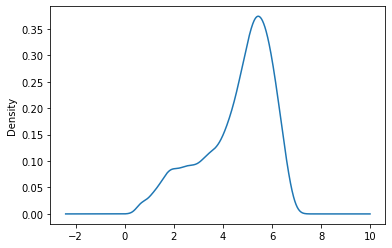

In [26]:
#进行log1p变换
import math
train['count_log']=train['count'].apply(lambda x: math.log(x+1))
train['count_log'].plot(kind='kde')

In [27]:
#对季节、天气、weekday等进行独热编码,并保留原属性编码，后续进行特征挑选
train=pd.get_dummies(train,columns=['season2'])
train=pd.get_dummies(train,columns=['weather2'])

test=pd.get_dummies(test,columns=['season2'])
test=pd.get_dummies(test,columns=['weather2'])

In [28]:
All_feature_columns = ['season','weather','temp','atemp','humidity','windspeed',
                        'year','holiday','workingday','month','day','hour','week','weekday','peak',
                       'season2_Fall','season2_Spring','season2_Summer','season2_Winter',
                       'weather2_Clear','weather2_Heavy_Rain','weather2_Light_Snow','weather2_Mist']

RFR_feature_columns = ['weather','temp','atemp','windspeed',
                       'workingday','season','holiday',
                       'hour','weekday','week','peak',
                       'season2_Fall','season2_Spring','season2_Summer','season2_Winter',
                      'weather2_Clear','weather2_Heavy_Rain','weather2_Light_Snow','weather2_Mist']

GBR_feature_columns =['weather','temp','atemp','humidity','windspeed',
                       'holiday','workingday','season',
                       'hour','weekday','year',
                      'season2_Fall','season2_Spring','season2_Summer','season2_Winter',
                       'weather2_Clear','weather2_Heavy_Rain','weather2_Light_Snow','weather2_Mist']

In [29]:
#拆分出训练数据
RFR_X_train=train[RFR_feature_columns].values
RFR_X_test=test[RFR_feature_columns].values

GBR_X_train=train[GBR_feature_columns].values
GBR_X_test=test[GBR_feature_columns].values

y_casual=train['casual'].apply(lambda x: np.log1p(x)).values
y_registered=train['registered'].apply(lambda x: np.log1p(x)).values
y_count=train['count'].apply(lambda x: np.log1p(x)).values

X_date=test['datetime'].values

In [30]:
#评价标准RMSLE
def rmsle(y_real, y_pre):    
    log1 = np.log(y_real+1)
    log2 = np.log(y_pre+1)    
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [31]:
#拆分模型训练集
from sklearn.model_selection import train_test_split
X_train = train[All_feature_columns].values
xd_train,xd_test,yd_train,yd_test = train_test_split(X_train,y_count,random_state=0)
#对各种回归模型进行训练、调参、测试
##LGBM
from lightgbm import LGBMRegressor
def LGBM_model():
    LGBM = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=1000, max_depth=10,
                                metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
    LGBM.fit(xd_train, yd_train)
    # 给出训练数据的预测值
    pre_test = LGBM.predict(xd_test)
    # 计算RMSLE
    score = rmsle(yd_test,pre_test)
    return score

##随机森林
from sklearn.ensemble import RandomForestRegressor
def RandomForest_model():
    RFR = RandomForestRegressor(n_estimators = 1000, max_depth=15, random_state=0,n_jobs = -1)
    RFR.fit(xd_train,yd_train)
    # 给出训练数据的预测值
    pre_test = RFR.predict(xd_test)
    # 计算RMSLE
    score = rmsle(yd_test,pre_test)
    return score

##决策树
from sklearn.tree import DecisionTreeRegressor
def DecisionTree_model():
    DTR = DecisionTreeRegressor(max_features='sqrt', splitter='random', min_samples_split=4, max_depth=10)
    DTR.fit(xd_train,yd_train)
    # 给出训练数据的预测值
    pre_test = DTR.predict(xd_test)
    # 计算RMSLE
    score = rmsle(yd_test,pre_test)
    return score

##集成学习梯度提升决策树
from sklearn.ensemble import GradientBoostingRegressor
def GradientBoosting_model():
    GBR = GradientBoostingRegressor(n_estimators = 1000, max_depth = 5, random_state = 0)
    GBR.fit(xd_train,yd_train)
    # 给出训练数据的预测值
    pre_test = GBR.predict(xd_test)
    # 计算RMSLE
    score = rmsle(yd_test,pre_test)
    return score

##逻辑斯蒂回归
from sklearn.linear_model import LogisticRegression
def Logisic_model():
    LG = LogisticRegression(penalty="l2",tol=0.0001, C=1.0, solver= "lbfgs", max_iter=3000,multi_class='ovr', verbose=O)
    LG.fit(xd_train,yd_train)
    # 给出训练数据的预测值
    pre_test = LG.predict(xd_test)
    # 计算RMSLE
    score = rmsle(yd_test,pre_test)
    return score

##AdaBoost
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost_model():
    ABR = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=1000)
    ABR.fit(xd_train,yd_train)
    # 给出训练数据的预测值
    pre_test = ABR.predict(xd_test)
    # 计算RMSLE
    score = rmsle(yd_test,pre_test)
    return score

In [32]:
#各种模型的RMSLE评价
print("LGBM_model:             ",LGBM_model())
print("RandomForest_model:     ",RandomForest_model())
print("DecisionTree_model:     ",DecisionTree_model())
print("GradientBoosting_model: ",GradientBoosting_model())
print("AdaBoost_model:         ",AdaBoost_model())

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
LGBM_model:              0.08594700914643276
RandomForest_model:      0.08391435541327587
DecisionTree_model:      0.22383235363815807
GradientBoosting_model:  0.0835690848275912
AdaBoost_model:          0.1571751462623098


In [33]:
#随机森林模型
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 1000, 
          'max_depth': 15, 
          'random_state': 0, 
          'min_samples_split' : 5, 
          'n_jobs': -1}

RFR1 = RandomForestRegressor(**params)
RFR1.fit(RFR_X_train,y_casual)
print("model拟合程度:",RFR1.score(RFR_X_train,y_casual))

RFR2 = RandomForestRegressor(**params)
RFR2.fit(RFR_X_train,y_registered)
print("model拟合程度:",RFR2.score(RFR_X_train,y_registered))

RFR3 = RandomForestRegressor(**params)
RFR3.fit(RFR_X_train,y_count)
print("model拟合程度:",RFR3.score(RFR_X_train,y_count))

model拟合程度: 0.9626319689534009
model拟合程度: 0.9742280635936635
model拟合程度: 0.9757046602261039


In [34]:
#集成学习梯度提升决策树
from sklearn.ensemble import GradientBoostingRegressor

params2 = {'n_estimators': 150, 
           'max_depth': 5, 
           'random_state': 0, 
           'min_samples_leaf' : 10, 
           'learning_rate': 0.1, 
           'subsample': 0.7, 
           'loss': 'ls'}

GBR1 = GradientBoostingRegressor(**params2)
GBR1.fit(GBR_X_train,y_casual)
print("model拟合程度:",GBR1.score(GBR_X_train,y_casual))

GBR2 = GradientBoostingRegressor(**params2)
GBR2.fit(GBR_X_train,y_registered)
print("model拟合程度:",GBR2.score(GBR_X_train,y_registered))

GBR3 = GradientBoostingRegressor(**params2)
GBR3.fit(GBR_X_train,y_count)
print("model拟合程度:",GBR3.score(GBR_X_train,y_count))

model拟合程度: 0.9203957622947261
model拟合程度: 0.9690481215133022
model拟合程度: 0.9693564748984175


In [35]:
RFR_pre_casual = RFR1.predict(RFR_X_test)
RFR_pre_casual=np.exp(RFR_pre_casual)-1
RFR_pre_registered = RFR2.predict(RFR_X_test)
RFR_pre_registered=np.exp(RFR_pre_registered)-1
RFR_pre = RFR_pre_casual+RFR_pre_registered

GBR_pre_casual = GBR1.predict(GBR_X_test)
GBR_pre_casual=np.exp(GBR_pre_casual)-1
GBR_pre_registered = GBR2.predict(GBR_X_test)
GBR_pre_registered=np.exp(GBR_pre_registered)-1
GBR_pre = GBR_pre_casual+GBR_pre_registered

submit1 = pd.DataFrame({'datetime':X_date,'count':0.2*RFR_pre+0.8*GBR_pre})
submit1.to_csv('/kaggle/working/submisssion_1.csv',index=False)

In [36]:
RFR_pre_count = RFR3.predict(RFR_X_test)
RFR_pre_count = np.exp(RFR_pre_count)-1
GBR_pre_count = GBR3.predict(GBR_X_test)
GBR_pre_count = np.exp(GBR_pre_count)-1

pre_count=0.2*RFR_pre_count+0.8*GBR_pre_count
submit2 = pd.DataFrame({'datetime':X_date,'count':pre_count})
submit2.to_csv('/kaggle/working/submisssion_2.csv',index=False)